# Face recognition

# 0. Installation des dépendances

In [28]:
# executer cette cellule pour charger l'ensemble des fonctions/librairies utiles
from IPython.core.display import HTML
import requests
#theme_url = "https://raw.githubusercontent.com/ninjasoul/IPython_NB_Config/master/custom.css"
theme_url = "https://raw.githubusercontent.com/ketch/HyperPython/master/custom.css"
rn = requests.get(theme_url)
HTML(rn.text)
from functools import partial
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib notebook
%matplotlib inline
import pip
pip.main('install imageio'.split())
import imageio
import skimage.morphology
import skimage.segmentation
import skimage.feature


plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['figure.figsize'] = 2, 2

def format_coord(x, y, image):
    x = int(x + 0.5)
    y = int(y + 0.5)
    try:
        val = str(image[y, x])
    except IndexError:
        val = "?"
    return "color={} @ [{}, {}]".format(val, y, x)

def display_image_nb(image, title='', cmap=None):
    fig, ax = plt.subplots(1,1)
    if cmap is None:
        ax.matshow(image)
    else:
        ax.matshow(image, cmap=cmap)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def display_image_color(image, title=''):
    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def draw_rectangle(y1, x1, y2, x2, color='red', ax=None, alpha=1):
    """ Add a rectangle on an image """
    if ax is None:
        ax = plt.gca()
    rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              fill=False, edgecolor=color, linewidth=2, alpha=alpha)
    ax.add_patch(rect)

print("OK let's go")

You are using pip version 7.1.2, however version 8.1.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


OK let's go


# 1. Chargement des jeux de données


## 1.1 Jeu de données de visages

Nous utilisons le jeu de données **Labeled Faces in the Wild Home** (http://vis-www.cs.umass.edu/lfw/).

La fonction fetch_lfw_people du package **sklearn.dataset** permet de télécharger facilement ce jeu de données (aide en ligne disponible ici: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)


De façon à limiter le nombre d'images nous n'utiliserons que les visages pour lesquels nous disposons de plus de 70 images dans la base.


In [29]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=20, slice_=(slice(69, 69+120), slice(78, 78+100)))


Loading LFW people faces from /home/seto/scikit_learn_data/lfw_home


- Quelle est la dimension de chaque image ?
- Combien d'images avez vous dans le tableau lfw_people ?
- Affichez une image de la base


height 60
width 50
nombre d'image 3023


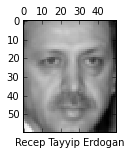

In [30]:
n_samples, h, w = lfw_people.images.shape
print("height %s" % h)
print("width %s" % w)
print("nombre d'image %s" % n_samples)

display_image_nb(lfw_people.images[32], title=lfw_people.target_names[lfw_people.target[32]])

dataset_face = lfw_people.images

## 1.2 Jeu de données "absence de visage"

Nous utilisons des images de type *background*, ne contenant pas de visage. Les images sont disponibles ici: http://tutorial-haartraining.googlecode.com/svn/trunk/data/negatives/

De façon à faciliter leur téléchargement, les images sont aussi disponibles ici : 
- http://srand.fr/negative_image.tar.gz 
- https://www.dropbox.com/s/zhmv58rbcfu61q3/negative_image.tar.gz?dl=0

Téléchargez cette archive.

In [31]:
chemin_vers_archive = './'  # a compléter : chemin vers le fichier, utilisez la touche tabulation pour avoir la complétion



In [32]:
chemin_vers_archive = '/home/seto/dataset/negative_image.tar.gz'

# décompressez l'archive, vous pouvez aussi utiliser un outil tels que winrar pour décompresser l'archive
import tarfile
tar_obj = tarfile.open(chemin_vers_archive)
tar_obj.extractall('./')

    

De façon à obtenir des images de tailles comparables à celles des images de la base visages, nous prétraitons les images. Le code suivant découpe chaque image en sous-images de taille (62 x 47) et créé un tableau contenant toutes ses sous images.

Nous ne gardons que 20000 images dans ce tableau.

In [33]:
import imageio
import glob

max_i = 60
max_j = 50
negative_jpg_files = glob.glob('./negative_image/*.jpg')
negative_dataset = []
for image_file in negative_jpg_files:
    data = imageio.imread(image_file)
    tab = skimage.util.view_as_windows(data, (max_i, max_j), 100)
    for i in range(tab.shape[0]):
        for j in range(tab.shape[1]):
            negative_dataset.append(tab[i,j])
    if len(negative_dataset) > 20000:
        break
negative_dataset = np.array(negative_dataset)

print(negative_dataset.shape)

(20008, 60, 50)


 - afficher 5 images du tableau negative_dataset

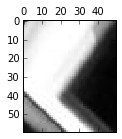

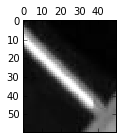

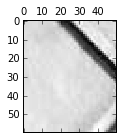

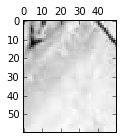

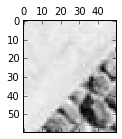

In [34]:
display_image_nb(negative_dataset[0])
display_image_nb(negative_dataset[1])
display_image_nb(negative_dataset[2])
display_image_nb(negative_dataset[3])
display_image_nb(negative_dataset[4])

 De façon à avoir le même nombre d'image dans la base visages et dans la bases 'absence de visages' nous sélectionnons un sous ensemble des images de façon aléatoires dans le tableau negative_dataset. 

(60, 50)


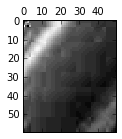

In [35]:
indexes = np.random.choice(negative_dataset.shape[0], len(dataset_face))
dataset_no_face = negative_dataset[indexes, :, :]
display_image_nb(dataset_no_face[1000])
print(dataset_no_face[1000].shape)

In [36]:
dataset_no_face.shape

(3023, 60, 50)

# 2. Extraction de features

La fonction compute_feature_vect permet d'extraire pour une image les histogrames des local binary pattern. Les différents histogrames sont concaténés dans un vecteur.

<img src="http://srand.fr/lbp_histogram.png">


Pour plus d'information: http://cs229.stanford.edu/proj2008/Jo-FaceDetectionUsingLBPfeatures.pdf


In [37]:
from skimage.feature import local_binary_pattern
def compute_feature_vect(image, debug=False):
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'
    lbp = local_binary_pattern(image, n_points, radius, METHOD)
    n_bins = 18
    hists = []
    if debug:
        display_image_nb(image)
    I = image.shape[0] / 6
    J = image.shape[1] / 5
    step = 10
    tab = skimage.util.view_as_blocks(lbp, (I, J))
    #tab = skimage.util.view_as_windows(lbp, (I,J), step=step)
    c = 0
    colors = ['blue', 'green', 'red']
    for i in range(tab.shape[0]):
        for j in range(tab.shape[1]):
            c+=1
            sub = tab[i, j]
            hist, _ = np.histogram(sub, normed=True, bins=n_bins, range=(0, n_bins))
            hists.append(hist.flatten())
            if debug:
                draw_rectangle(i*step, j*step, i*step+I-1, j*step+J-1, color=colors[c%len(colors)], alpha=0.8)
    return np.array(hists).flatten()


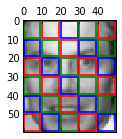

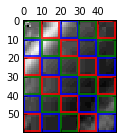

In [38]:
a = compute_feature_vect(dataset_face[1000], debug=True)
b = compute_feature_vect(dataset_no_face[1000], debug=True)

In [39]:
print(a.shape)

(540,)


# 3. Apprentissage

Dans cette section nous utiliserons la librairie python sklearn, comme lors du tp2.



Nous allons créer une liste X d'images et une liste Y de label associé à ses images.

Pour chaque image du jeu de données dataset_face nous associeront le label 'face'
Pour chaque image du jeu de données dataset_noface nous associeront le label 'noface'

Créez ces deux listes (vous pouvez vous aider de la fonction append ainsi que d'une boucle for)

In [41]:
# en utilisant une boucle for
X = []
Y = []
for image in dataset_face:
    X.append( compute_feature_vect(image))
    Y.append('face')
for image in dataset_no_face:
    X.append(compute_feature_vect(image))
    Y.append('noface')
print(len(Y))

6046


In [42]:
np.array(Y).shape

(6046,)

Créez un classifieur de type k-nearest neighbors, avec k = 10

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

In [44]:
clf = KNeighborsClassifier()

Utilisez la fonction cross_val_score afin d'évaluer le taux de bonne reconnaissance.

In [45]:
cross_val_score(clf, X, Y)

array([ 0.95535714,  0.96031746,  0.95978153])

Le code suivant permet de partitionner le jeu de donnée en un ensemble de test et un ensemble d'entrainement. 
Le classifieur est alors entrainé à reconnaitre chaque classe (visage vs. absence de visage) sur le jeu d'entrainement (méthode fit).

Nous affichons ensuite le score obtenu sur le jeu de test, ainsi que la matrice de confusion associé.

Expliquez à quoi correspondent les nombres dans la matrices de confusions.


In [46]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, test_size=0.1)

clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

prediction_on_testing_data = clf.predict(X_test)
print(confusion_matrix(y_test, prediction_on_testing_data))

0.96694214876
[[289   1]
 [ 19 296]]


In [47]:
np.sum(np.array(y_test) == 'face')

290

Entrainez une nouvelle fois le classifieur mais cette fois en utilisant l'ensemble du jeu de donnée.


In [49]:
clf.fit(X,Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

In [ ]:
# entrainez un second classifieur de type adaboost


In [50]:
from sklearn.ensemble import AdaBoostClassifier

clf2 = AdaBoostClassifier()
print(cross_val_score(clf, X, Y))
clf2.fit(X,Y)

[ 0.95535714  0.96031746  0.95978153]


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

# 4. Détection de visage 

In [51]:

def check_image(image_test, window_size = (60, 50), clf=clf):
    STEP = max(window_size) /3
    tab = skimage.util.view_as_windows(image_test, window_size, STEP)
    display_image_nb(image_test)
    for i in range(tab.shape[0]):
        for j in range(tab.shape[1]):
            block = tab[i, j]
            features = compute_feature_vect(block)
            prediction = clf.predict(features.flatten())
            #print(prediction)
            if prediction == 'face':
                draw_rectangle(i*STEP, j*STEP, i*STEP+window_size[0], j*STEP+window_size[1], color='green')

            #if prediction != 'face':
             #   draw_rectangle(i*STEP, j*STEP, i*STEP+window_size[0], j*STEP+window_size[1], color='red')
                #display_image_nb(block)
            
        

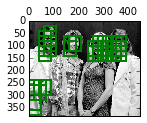

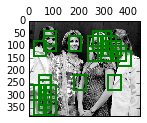

In [52]:
url = "http://www.franceinfo.fr/sites/default/files/2014/04/24/1396433/images/principale/ABBA_-_TopPop_1974_5.png"
image_test = skimage.color.rgb2gray(imageio.imread(url))
abba = skimage.transform.rescale(image_test, 0.9)
check_image(abba)
check_image(abba, clf=clf2)

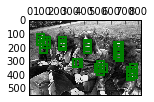

In [53]:
img_test = "http://www.geeksofdoom.com/GoD/img/2015/02/black-sabbath-1970.jpg"
image = skimage.color.rgb2gray(imageio.imread(img_test))
image = skimage.transform.rescale(image, 0.4)
check_image(image, clf=clf)

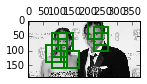

In [54]:
url = 'http://www.metronews.fr/_internal/gxml!0/r0dc21o2f3vste5s7ezej9x3a10rp3w$2cy31g3wqku201imd2kxxrrbamo4kch/Capture-decran-2015-12-26-a-17.jpeg'
image = imageio.imread(url)
image = skimage.color.rgb2gray(image)
image = skimage.transform.rescale(image, 0.44)
check_image(image, clf=clf2)


Testez la méthode sur 10 images (smartphone, ou sur le net). Pensez a utilisez la fonction rescale comme illustrez dans les exemples précédents, afin d'avoir une fenêtre d'analyse a peu près égale à la taille des visage présent dans l'image.

Quelles sont les limites du système ?
Que proposez vous pour y remédier ? 


# Bonus

Où est Charlie. En reprenant le mếme procédé que précédemment, proposez une solution au problème où est Charlie (sur la 3 ème image).

In [ ]:
positive_image = imageio.imread('http://images3.wikia.nocookie.net/__cb20071001170840/waldo/images/a/ae/LandofWaldos.jpg')
display_image_color(positive_image)

In [ ]:
lab_image = skimage.color.rgb2gray(positive_image)


In [ ]:
negative_dataset = imageio.imread('http://srand.fr/where_is_waldo_false.png')
display_image_color(negative_dataset)

In [ ]:
# Testing on an other image
where_is_waldo_image = "http://4.bp.blogspot.com/-xf61k0lalPY/Ttcun6OATdI/AAAAAAAABBE/ofl_qivcMQw/s1600/Play+Wheres+Waldo+Online+Puzzle+Game+Gold+Rush.jpg"
test_image = imageio.imread(where_is_waldo_image)
display_image_color(test_image)